### Libraries 📚⬇

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [2]:
# !pip install -q -U segmentation-models-pytorch albumentations 
import segmentation_models_pytorch as smp

import segmentation_models_pytorch.utils.metrics



In [3]:
# x_train_dir = 'train/'
# y_train_dir = 'train_masks/'
# x_valid_dir = 'val/'
# y_valid_dir = 'val_masks/'
# x_test_dir = 'test/'
# y_test_dir = 'test_masks/'

### Defining train / val / test directories 📁

In [24]:
DATA_DIR = './4400_1500/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_masks')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_masks')

x_test_dir = os.path.join(DATA_DIR, 'testpred')
y_test_dir = os.path.join(DATA_DIR, 'test_masks')

In [25]:
class_dict = pd.read_csv("label_class_dict.csv")
class_dict

,name,r,g,b
0,background,0,0,0
1,fruit,255,255,255


In [26]:
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'fruit']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


#### Shortlist specific classes to segment

In [27]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'fruit']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'fruit']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


### Helper functions for viz. & one-hot encoding/decoding

In [28]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    return x

In [29]:
class EggplantDataset(torch.utils.data.Dataset):

    """
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

#### Visualize Sample Image and Mask 📈

image shape:  (4400, 1500, 3)


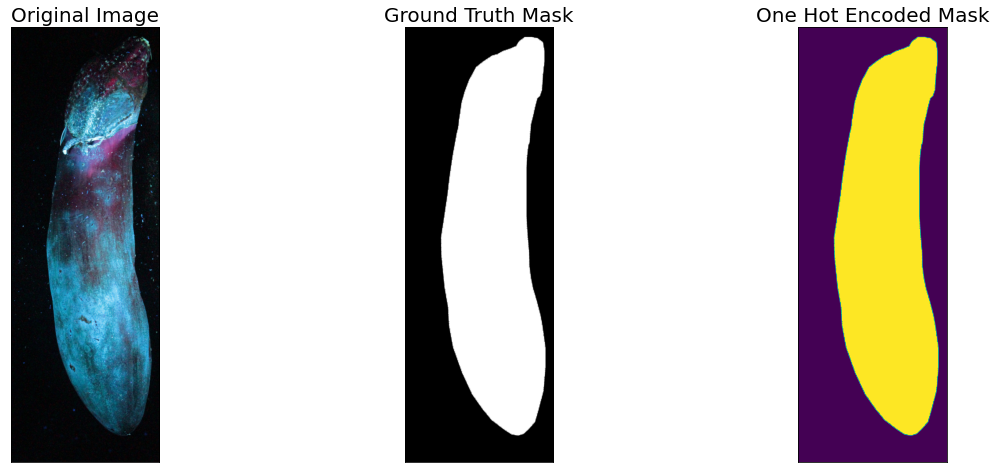

In [10]:
dataset = EggplantDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[8]

print("image shape: ", image.shape)

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Defining Augmentations 🙃

In [11]:
def get_training_augmentation():
    train_transform = [    
        album.Resize(height=4400, width=1500, always_apply=True),
        album.RandomCrop(height=256, width=256, always_apply=True),
#         album.Resize(min_height=4400, min_width=1500, always_apply=True, keep_ratio=True)
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.Resize(height=4400, width=1500, always_apply=True),
        album.PadIfNeeded(min_height=4416, min_width=1504, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

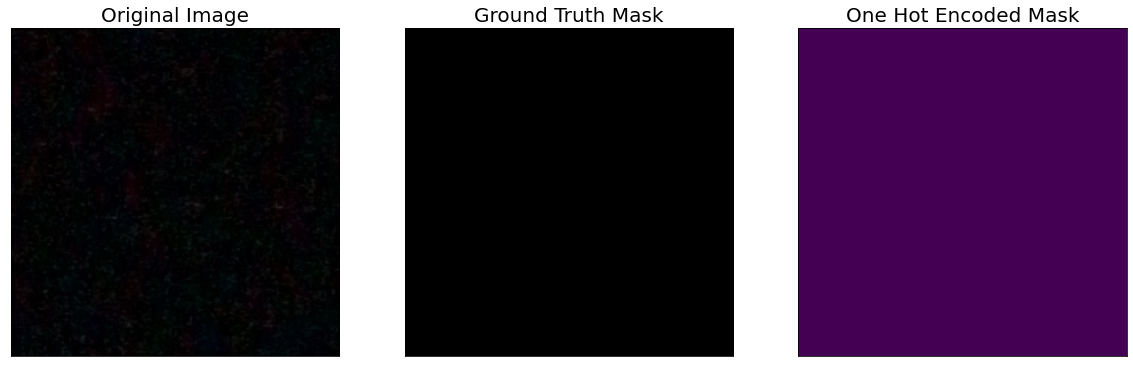

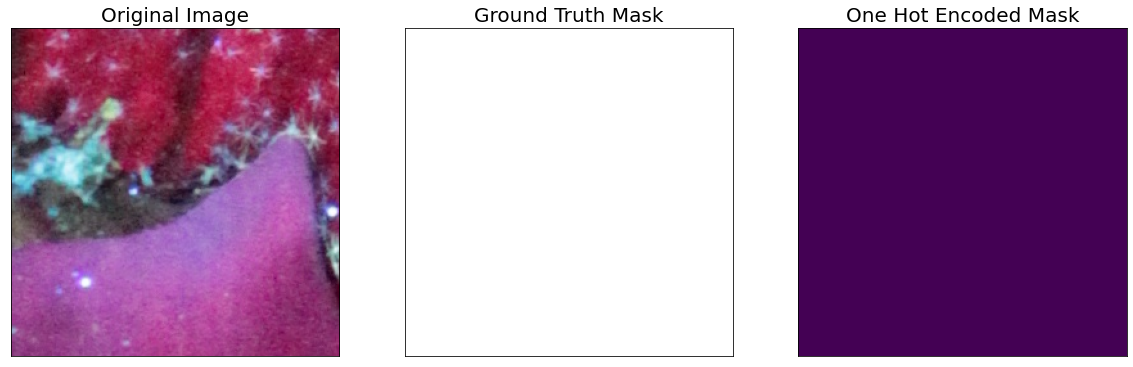

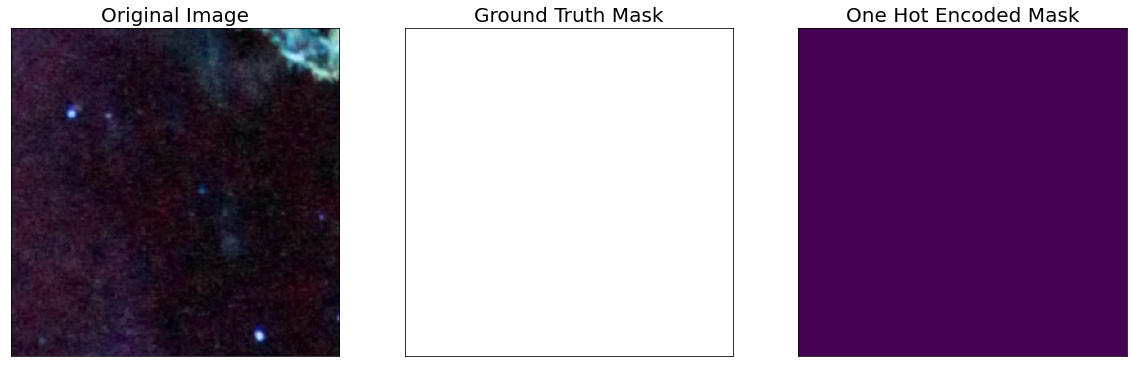

In [12]:
augmented_dataset = EggplantDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

## Training UNet with Pretrained ResNet50 Encoder

<h3><center>UNet Model Architecture</center></h3>
<img src="https://miro.medium.com/max/2824/1*f7YOaE4TWubwaFF7Z1fzNw.png" width="750" height="750"/>
<h4><center><a href="https://arxiv.org/abs/1505.04597">Image Courtesy: UNet [Ronneberger et al.]</a></center></h4>

### Model Definition

In [13]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

#### Get Train / Val DataLoaders

In [14]:
# Get train and val dataset instances
train_dataset = EggplantDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = EggplantDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

#### Set Hyperparams

In [15]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 10

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth'):
    model = torch.load('../input/unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth', map_location=DEVICE)

In [16]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

### Training UNet

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')

### Prediction on Test Data

In [17]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model_96.1.pth'):
    best_model = torch.load('./best_model_96.1.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input//unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth'):
    best_model = torch.load('../input//unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


Image:  (4416, 1504, 3)


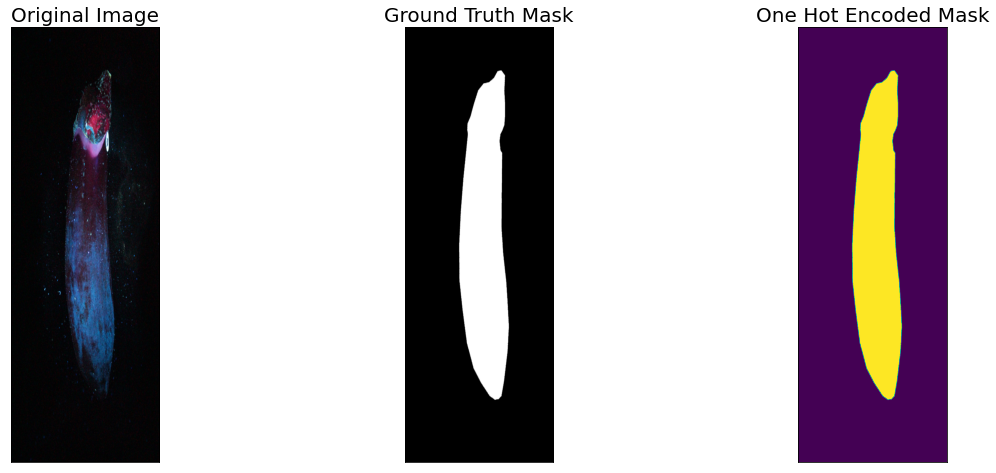

In [30]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = EggplantDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = EggplantDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

print("Image: ", image.shape)

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536*1536 because of 18px padding on all sides. 
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [31]:
# # Center crop padded image / mask to original image dims
# def crop_image(image, target_image_dims=[1500,4400,3]):
   
#     target_size = target_image_dims[0]
#     image_size = len(image)
#     padding = (image_size - target_size) // 2

#     return image[
#         padding:image_size - padding,
#         padding:image_size - padding,
#         :,
#     ]

In [32]:
import numpy as np

def crop_image(image, target_image_dims=[4400, 1500, 3]):
   
    print(f"Input image shape: {image.shape}")
    
    actual_dims = np.array(image.shape)[:2]
    target_dims = np.array(target_image_dims)[:2]
    
    # Calculate scaling factor
    scale = np.min(target_dims / actual_dims)
    
    # Calculate new dimensions after scaling
    new_dims = np.round(actual_dims * scale).astype(int)
    
    # Calculate padding
    pad = (target_dims - new_dims) // 2
    
    # Calculate crop range
    crop_range = np.array([pad, pad + new_dims])
    
    # Crop and pad image
    cropped_image = np.zeros(target_image_dims, dtype=image.dtype)
    cropped_image[
        crop_range[0, 0]:crop_range[1, 0],
        crop_range[0, 1]:crop_range[1, 1],
        :
    ] = image[
        :new_dims[0],
        :new_dims[1],
        :
    ]
    
    print(f"Cropped image shape: {cropped_image.shape}")
    
    return cropped_image


In [33]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [36]:
# Loop through each image in the test dataset
for idx in range(len(test_dataset)):

    # Get the image and ground truth mask for the current index
    image, gt_mask = test_dataset[idx]

    # Get a visual representation of the image and crop it
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    
    print("image_vis: ", image_vis.shape)

    # Convert the image to a tensor and move it to the device
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    # Use the trained model to predict the mask for the input image
    pred_mask = best_model(x_tensor)

    # Detach the prediction from the computation graph and convert to a numpy array
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()

    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))

    # Get prediction channel corresponding to eggplant
    pred_eggplant_heatmap = pred_mask[:,:,select_classes.index('fruit')]

    # Apply color coding to the predicted mask and crop it
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))

    # Convert the ground truth mask from `CHW` format to `HWC` format and apply color coding and cropping
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))

    # Combine the visual image, ground truth mask, and predicted mask horizontally and save it as an image
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    # Visualize the original image, ground truth mask, predicted mask, and eggplant heatmap
#     visualize(
#         original_image = image_vis,
#         ground_truth_mask = gt_mask,
#         predicted_mask = pred_mask,
#         predicted_eggplant_heatmap = pred_eggplant_heatmap
#     )


Input image shape: (4416, 1504, 3)
Cropped image shape: (4400, 1500, 3)
image_vis:  (4400, 1500, 3)


KeyboardInterrupt: 

In [41]:
import cv2
from skimage.color import rgb2lab

import os

import pandas as pd


In [47]:
import pandas as pd

# Create an empty list to store the results
results = []

# Loop through each image in the test dataset
for idx in range(len(test_dataset)):

    # Get the image and ground truth mask for the current index
    image, gt_mask = test_dataset[idx]
    
    print("Image: ", image.shape)

    # Get the corresponding image name from the original folder
    image_name = os.path.basename(test_dataset.image_paths[idx])

    # Get a visual representation of the image and crop it
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))

    # Convert the image to a tensor and move it to the device
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    # Use the trained model to predict the mask for the input image
    pred_mask = best_model(x_tensor)

    # Detach the prediction from the computation graph and convert to a numpy array
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()

    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))

    # Find contours on the predicted mask
    contours, _ = cv2.findContours((pred_mask[:,:,0] > 0.5).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original image
    image_with_contours = np.array(image.copy())
    cv2.drawContours(image_with_contours, contours, -1, (0, 0, 255), 2)
    
    pred_mask_rgb = np.repeat(pred_mask[..., np.newaxis], 3, axis=-1)

    # Convert the image and the overlaid mask to LAB color space
    image_lab = rgb2lab(image)
    overlaid_mask_lab = rgb2lab(pred_mask_rgb)

    # Extract R, G, B and L*, a*, b* values from each contour
    for i, contour in enumerate(contours):
        
        # Create a mask for the current contour
        contour_mask = np.zeros_like(pred_mask[:,:,0])
        cv2.drawContours(contour_mask, contours, i, 1, -1)

        # Apply the mask to the original image and get the RGB values
        R_values = (image[:,:,0]*contour_mask).ravel()
        G_values = (image[:,:,1]*contour_mask).ravel()
        B_values = (image[:,:,2]*contour_mask).ravel()

        # Apply the mask to the overlaid mask and get the LAB values
        L_values = (overlaid_mask_lab[:,:,0]*contour_mask).ravel()
        a_values = (overlaid_mask_lab[:,:,1]*contour_mask).ravel()
        b_values = (overlaid_mask_lab[:,:,2]*contour_mask).ravel()

        # Create a dictionary to store the results for the current contour
        result_dict = {
            "Image Name": image_name,
            "Contour ID": i,
            "R Values": R_values,
            "G Values": G_values,
            "B Values": B_values,
            "L* Values": L_values,
            "a* Values": a_values,
            "b* Values": b_values
        }

        # Append the dictionary to the results list
        results.append(result_dict)

    # Save the image with contours to disk
    cv2.imwrite(f"{image_name[:-4]}_contours.png", image_with_contours)


# Convert the results list to a pandas dataframe
df = pd.DataFrame(results)

# Save the dataframe to a CSV file
df.to_csv("results.csv", index=False)


Image:  (3, 4416, 1504)
Input image shape: (4416, 1504, 3)
Cropped image shape: (4400, 1500, 3)


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\matrix_c.cpp:190: error: (-5:Bad argument) Unknown array type in function 'cv::cvarrToMat'


### Model Evaluation on Test Dataset

In [37]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 6/6 [03:07<00:00, 31.19s/it, dice_loss - 0.5047, iou_score - 0.1627] 
Evaluation on Test Data: 
Mean IoU Score: 0.1627
Mean Dice Loss: 0.5047


### Plot Dice Loss & IoU Metric for Train vs. Val

In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()